# Ejercicio de predicción de precios de viviendas

**Desarrollado por:** Orlando Patricio Chacón Molina

**Fecha de creación:** 2022-02-12

**Fecha de actualización:** 2022-02-13

## Descripción
Predecir los precios de las viviendas  para el condado de King utilizando el conjunto de datos disponible en [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). Se utilizará Bagged Trees y RandomForest.

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Leer dataset
filename = 'data/kc_house_data.csv'
df = pd.read_csv(filename)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


## Limpieza de datos.
La columna date se tratará como un dato entero, eliminando el texto 'T000000'.

In [4]:
# Se trata a la columna 'date' como una variable de tipo entero, que aparentemente tendría significado
# debido a que el formato de la fecha luego de eliminar 'T000000' es YYYYMMDD.
df['date'] = df['date'].apply(lambda x: (int(x.replace('T000000','')) if isinstance(x,str) else x))
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
# Creación del array predLabels, que contine los nombres de las columnas predictoras.
# Se han omitido: id, price y zip code.
# Se realizaron pruebas omitiendo lat y long, sin embargo, la precisión luego de
# eliminar estas variables decreció de 0.85 a 0.72 por lo cual se volvieron a incluir.
predLabels = df.iloc[:,1:2].columns.values.tolist() + df.iloc[:,3:16].columns.values.tolist()+ df.iloc[:,17:].columns.values.tolist()
targetLabel = df.iloc[:,2:3].columns.values.tolist()
predLabels

['date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

## División del conjunto de datos (Train-Test)

In [6]:
X = df[predLabels]
y = df[targetLabel]

# Dividir aleatoriamente el conjunto de datos en entrenamiento y pruebas.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state = 989837)


## Utilizando Bagging Trees

In [7]:
# Inicializar "Bagging regresor" si base_estimator=None, entonces se utilizará DecisionTreeRegressor.
regBt = BaggingRegressor(base_estimator=None, random_state=989837, max_samples=1.0)
regBt.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\env36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(random_state=989837)

In [8]:
# Obtener la precision del modelo, medido sobre el conjunto de datos de prueba. 
score = regBt.score(X_test,y_test)
print(f"Precisión Bagging Tree: {score}")

Precisión Bagging Tree: 0.8368559603165902


## Utilizando Random Forest

In [9]:
# Inicializar el modelo Random forest y establecer parámetros básicos
reg = RandomForestRegressor(n_jobs=100, oob_score=True, n_estimators=100, max_features=None, random_state=989837)
reg.get_params() # Mostrar todos los valores de los parámetros  

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 100,
 'oob_score': True,
 'random_state': 989837,
 'verbose': 0,
 'warm_start': False}

In [10]:
# Entrenar el modelo con el conjunto de datos de entrenamiento
reg.fit(X_train,y_train);

C:\ProgramData\Anaconda3\envs\env36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [14]:
# Obtener la precision del modelo, medido sobre el conjunto de datos de prueba. 
score = reg.score(X_test,y_test)
print(f"Precisión Random Forest: {score}")

Precisión Random Forest: 0.8502530780825867


## Características más importantes del modelo

In [12]:
list(zip(predLabels, reg.feature_importances_))

[('date', 0.010906438851566216),
 ('bedrooms', 0.0027737615360804),
 ('bathrooms', 0.007831587701333251),
 ('sqft_living', 0.4002495042676088),
 ('sqft_lot', 0.013839673630627321),
 ('floors', 0.0015956936118275574),
 ('waterfront', 0.02873669765531635),
 ('view', 0.010526361913111598),
 ('condition', 0.002540089150963732),
 ('grade', 0.18972433254493057),
 ('sqft_above', 0.02256909895667621),
 ('sqft_basement', 0.009966445864650056),
 ('yr_built', 0.03126113157080721),
 ('yr_renovated', 0.0017717258810894783),
 ('lat', 0.14429626188619127),
 ('long', 0.0691254178318778),
 ('sqft_living15', 0.035560040678259956),
 ('sqft_lot15', 0.01672573646708229)]

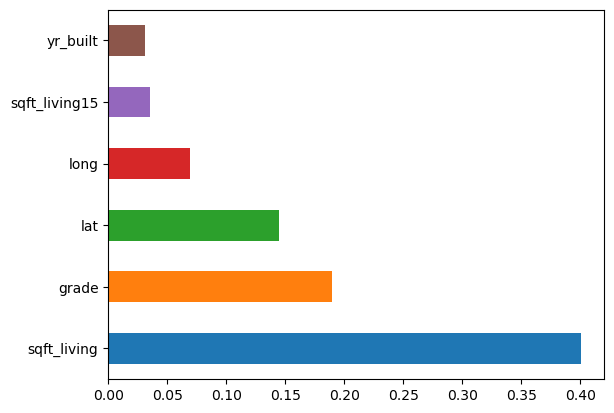

In [13]:
plt.style.use('default')
feat_importance = pd.Series(reg.feature_importances_, index=predLabels)
feat_importance.nlargest(6).plot(kind='barh')

## Parámetros que se podrían ajustar
Podría resultar conveniente aplicar un enfoque similar al mostrado en el artículo [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74), donde presentan un método para probar varias combinaciones aleatorias de los hiperparámetros del algoritmo y seleccionar aquellas que presenten el menor error y mayor precisión. En [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) se presenta un método para probar el parámetro "max_features" con los valores: 'sqrt', 'log2' y None en combinación con el parámetro 'n_stimators' desde 15 hasta 150, para finalmente mostrar un gráfico de los errores todas las combinaciones. 